<a href="https://colab.research.google.com/github/Samsonite27/Samsonite27.github.io/blob/main/Network_Project/Network_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

So just for reference this was a first year project, where we had to demonstrate ability to manipulate networks and research and apply clustering methods. I have moved the code from its original jupyter notebook here.

For reference, the first section was focused around building up the code for a spectral bipartition cluster method, as a result scipy and other similar libraries were not to be used.

A lot of this code is not perfect and in places a bit scrappy. But like most of this directory is aimed at showcasing growth. I've attempted to restructure to a semi-readble format but due to the process of the project a lot of the explanation of the math is excluded here.

Various assorted notes are at the end.

In [41]:
import networkx as nx #for analysing networks
import numpy as np #for maths functionality, including vectors and matrices
import matplotlib.pyplot as plt #for visualising data

#Used later
import scipy.sparse.linalg
import sklearn
import sklearn.cluster
from sklearn.metrics import jaccard_score

The number of nodes is 34
The number of edges is 78


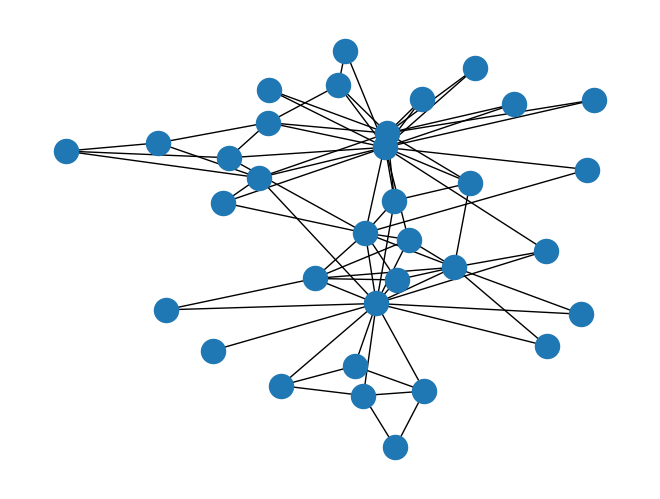

In [42]:
#Preliminaries, basic visualisation of the graph we worked with

ZKC_graph = nx.karate_club_graph() # load the Zachary Karate Club network data from the NetworkX package
print("The number of nodes is", ZKC_graph.number_of_nodes()) # print the number of nodes
print("The number of edges is", ZKC_graph.number_of_edges()) # print the number of edges

positions = nx.spring_layout(ZKC_graph) # generate a layout for the nodes (you can try different ones by re-compiling this cell), and comment this line out or save the layout if you want to use the same one for subsequent visualizations
nx.draw(ZKC_graph, positions) # visualize the network (note: for those of you interested in further explore network visualizations, Gephi https://gephi.org is a useful tool)
plt.show()


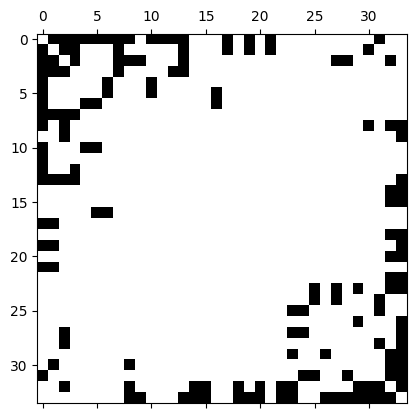

The matrix has 34 rows and 34 columns.
The matrix has a suitable adjacency matrix.


In [43]:
#An adjacency matrix visualisation

A = nx.to_numpy_array(ZKC_graph) # convert the network into an adjacency matrix
A = np.where(A >= 1, 1, 0) # binarize the network (the entry is 1 for any nonzero edge weight and 0 otherwise)
plt.spy(A) # visualize the adjacency matrix of the network (with black = 1 and white = 0)
plt.show()

def A1_verify_1_0(matrix):
    num_rows, num_columns = np.shape(matrix)
    print('The matrix has ' + str(num_rows) + ' rows and ' + str(num_columns) + ' columns.')
    for i in np.unique(matrix):
        if i == 0 or i == 1:
            continue
        else:
            return print('The matrix' + ' does not have a suitable adjacency matrix.')
    return print('The matrix' + ' has a suitable adjacency matrix.')

A1_verify_1_0(A)

[0]


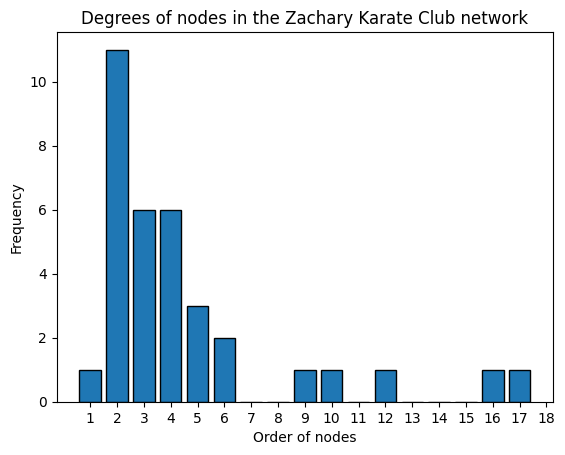

In [44]:
# This whole section is to point out that real-world graphs have a defree sequence that follows a power law distribution

def deg_node(A,i):
    k = 0
    for j in range(A.shape[0]):
        k = k + A[i][j]
    return k

def is_Symmetric(matrix):
    return np.unique(matrix - np.transpose(matrix))

print(is_Symmetric(A)) #is zero hence symmetric, hence undirected, hence A[i][j] = A[j][i] for all i, j

def list_node_degrees(matrix):
    degree_array = np.array([deg_node(matrix, 0)])
    for i in range(1, matrix.shape[0]):
       degree_array = np.r_[degree_array, [deg_node(matrix, i)]]
    return degree_array

data = list_node_degrees(A)
plt.hist(data, bins=range(min(data), max(data) + 2), align='left', rwidth=0.8, edgecolor = 'black')
plt.xticks(range(min(data), max(data) + 2, 1))
plt.xlabel('Order of nodes')
plt.ylabel('Frequency')
plt.title('Degrees of nodes in the Zachary Karate Club network')
plt.show()


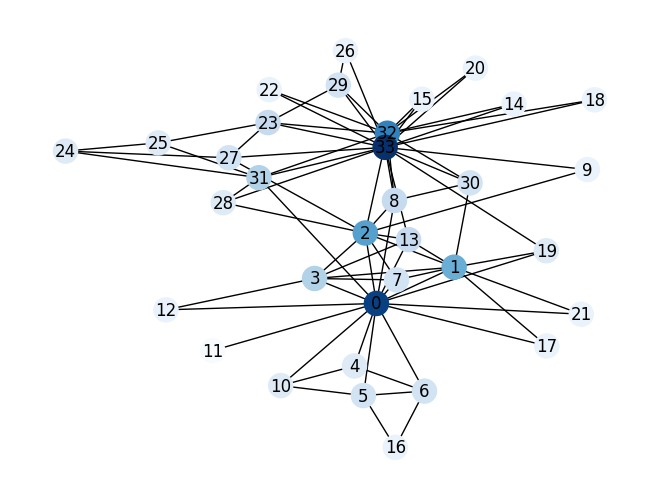

In [45]:
#Visualisation of degree sequence on network
k_seq = ZKC_graph.degree()
k_seq_np = np.array(k_seq)
k_seq_1darray = k_seq_np[:,1]
nx.draw(ZKC_graph, positions,node_color=k_seq_1darray, cmap=plt.cm.Blues, with_labels=True)
plt.show()

In [46]:
#Basic metrics
print('The mean degree is ' + str(np.mean(k_seq_1darray)))
print('The standard deviation for the degrees is ' + str(np.std(k_seq_1darray)))
print('The largest degree is ' + str(np.max(k_seq_1darray)))
print('The smallest degree is ' + str(np.min(k_seq_1darray)))

The mean degree is 4.588235294117647
The standard deviation for the degrees is 3.820360677912828
The largest degree is 17
The smallest degree is 1


In [47]:
#Calculation of laplacian

def get_Laplacian(matrix):
    laplacian_matrix = np.diagflat(list_node_degrees(matrix)) - matrix
    return laplacian_matrix

print(get_Laplacian(A))

[[16 -1 -1 ... -1  0  0]
 [-1  9 -1 ...  0  0  0]
 [-1 -1 10 ...  0 -1  0]
 ...
 [-1  0  0 ...  6 -1 -1]
 [ 0  0 -1 ... -1 12 -1]
 [ 0  0  0 ... -1 -1 17]]


In [48]:
def verify_0_total_sum(laplacian_matrix):
    '''
    Note as symmetric, i and j are interchangeable in code, do not have to
    verify for both row and columns
    '''

    for i in range(laplacian_matrix.shape[0]):
        k = 0
        for j in range(laplacian_matrix.shape[1]):
            k += laplacian_matrix[i][j]
        if k == 0:
            continue
        else:
            return print('Something is wrong, row and columns do not sum to zero')

    return print('Rows and columns sum to zero.')

print(verify_0_total_sum(get_Laplacian(A)))

Rows and columns sum to zero.
None


In [49]:
def get_Eigens(laplacian_matrix):
    return np.linalg.eigh(laplacian_matrix)

def get_EigenVectors(laplacian_matrix):
    null, eigen_vectors_transpose = get_Eigens(laplacian_matrix)
    return np.transpose(eigen_vectors_transpose)

def get_EigenValues(laplacian_matrix):
    list_eigen_values, null = get_Eigens(laplacian_matrix)
    return list_eigen_values

def get_corresponding_Eigen_Vector(laplacian_matrix, sorted_index_eigen_value):
    original_index = np.argsort(get_EigenValues(laplacian_matrix))[sorted_index_eigen_value]
    print(original_index)
    return get_EigenVectors(laplacian_matrix)[original_index,:]

print(get_corresponding_Eigen_Vector(get_Laplacian(A), 0))
print(get_corresponding_Eigen_Vector(get_Laplacian(A), 1))

0
[0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859]
1
[-0.11213743 -0.04128789  0.02321896 -0.05549978 -0.28460453 -0.32372722
 -0.32372722 -0.052586    0.05160128  0.09280089 -0.28460453 -0.21099295
 -0.1094613  -0.01474197  0.16275078  0.16275078 -0.42276533 -0.10018142
  0.16275078 -0.01363713  0.16275078 -0.10018142  0.16275078  0.15569457
  0.15302558  0.16096292  0.18710956  0.12766405  0.0951523   0.16765031
  0.07349964  0.09875343  0.13034546  0.11890326]


In [50]:
#Putting everything together nicely using a lot of functions from modules

def spectral_bipartitioning(A, k_seq):
    laplacian_matrix = np.diagflat(k_seq) - A
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    index_1 = np.argsort(eigenvalues)[1]
    partition = [val >= 0 for val in eigenvectors[:, index_1]]
    partition_array = 1*np.reshape(partition, A.shape[0])
    return partition_array

In [51]:
print(spectral_bipartitioning(A, list_node_degrees(A)))

[0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


[0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


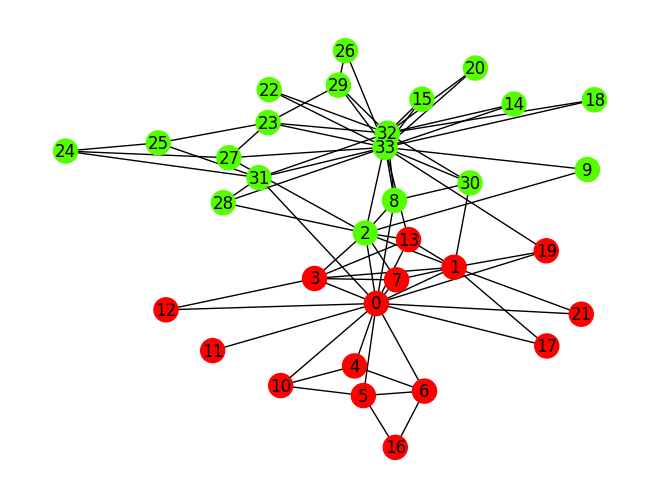

In [52]:
node_list_1darray = spectral_bipartitioning(A, list_node_degrees(A))
print(node_list_1darray)
nx.draw(ZKC_graph, positions,node_color=node_list_1darray, cmap=plt.cm.prism, with_labels=True)
plt.show()

In [53]:
#This function we found was a useful tool for visualisations in the presentation
#It allows you to input an adjacency matrix and be returned with the two smaller adjacency matricies representing the clusters
def adj_unzip(matrix):
    partition_array = spectral_bipartitioning(matrix, list_node_degrees(matrix))
    #Initialises emprt arrays
    adj_matrix_1 = np.array([])
    adj_matrix_2 = np.array([])

    #Loops through partition
    for i in range(len(partition_array)):
        if partition_array[i] == 1:
            #If node in that parition it will loop through again and see what other nodes are in that partition adding their connections
            a_i = []

            for j in range(matrix.shape[1]):
                if partition_array[j] == 1:
                    a_i.append(matrix[i][j])
                else:
                    continue
            adj_matrix_1 = np.append(adj_matrix_1, a_i)

        else:
            #This does the same but for the 0 case
            a_i = []

            for j in range(matrix.shape[1]):
                if partition_array[j] == 0:
                    a_i.append(matrix[i][j])
                else:
                    continue
            adj_matrix_2= np.append(adj_matrix_2, a_i)


    #This makes the matricies into square adjacecny matricies
    dimension_1 = int((adj_matrix_1.shape[0]) ** 0.5)
    adj_matrix_1 = np.reshape(adj_matrix_1, (dimension_1, dimension_1))

    dimension_2 = matrix.shape[0] - dimension_1
    adj_matrix_2 = np.reshape(adj_matrix_2, (dimension_2, dimension_2))


    return adj_matrix_1, adj_matrix_2

#Functions that return each partition rather than a tuple of partitions adjacency matrix
def get_adj_1(matrix):
    adj_1, null = adj_unzip(matrix)
    return adj_1

def get_adj_2(matrix):
    null, adj_2 = adj_unzip(matrix)
    return adj_2


In [54]:
#This was the beginning of the second section, exploring a different network with no meaningful clusters
#Instead we just saw the output of the algorithm

from google.colab import files
uploaded = files.upload()

fh = open("out.contiguous-usa", "rb")
contiguous = nx.read_edgelist(fh, comments='%', data=(("weight", float)))
fh.close()
print("The number of nodes is", contiguous.number_of_nodes()) # print the number of nodes
print("The number of edges is", contiguous.number_of_edges()) # print the number of edges

Saving out.contiguous-usa to out (3).contiguous-usa
The number of nodes is 49
The number of edges is 107


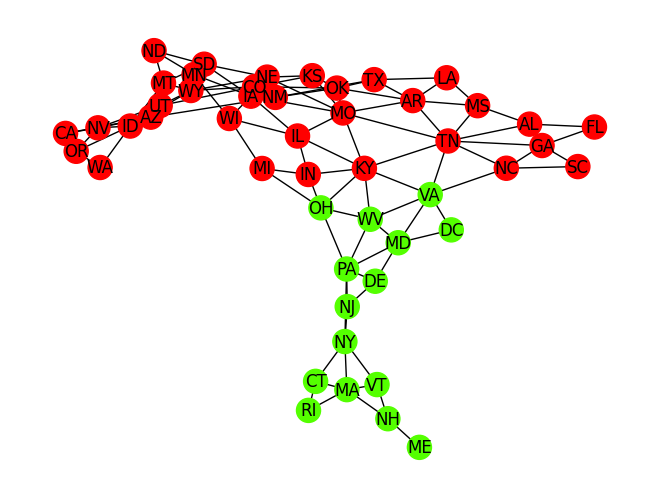

In [55]:
#Spectral bipartition

B = nx.to_numpy_array(contiguous)
B = np.where(B >= 1, 1, 0)

node_count = B.shape[0]

contiguous_positions = nx.spring_layout(contiguous)

k_seq2 = contiguous.degree()
k_seq_np2 = np.array(k_seq2, dtype=int)

partition_array2 = spectral_bipartitioning(B,k_seq_np2[:,1])

#This gives the dictionary for which node is which state to display in the graph instead of the node number.
state_dict = {'1': 'AL', '2': 'FL', '3': 'GA', '4': 'MS', '5': 'TN', '6': 'AR', '7': 'LA', '8': 'MO', '9': 'OK', '10': 'TX', '11': 'AZ', '12': 'CA', '13': 'NM', '14': 'NV'
 , '15': 'UT', '16': 'OR', '17': 'CO', '18': 'KS', '19': 'NE', '20': 'WY', '21': 'CT', '22': 'MA', '23': 'NY', '24': 'RI', '25': 'DC', '26': 'MD', '27': 'VA'
 , '28': 'DE', '29': 'NJ', '30': 'PA', '31': 'NC', '32': 'SC', '33': 'IA', '34': 'IL', '35': 'MN', '36': 'SD', '37': 'WI', '38': 'ID', '39': 'MT', '40': 'WA', '41': 'IN'
 , '42': 'KY', '43': 'MI', '44': 'OH', '45': 'WV', '46': 'NH', '47': 'VT', '48': 'ME', '49': 'ND'}

nx.draw(contiguous, contiguous_positions,node_color=partition_array2, cmap=plt.cm.prism,
                            with_labels=True, labels=state_dict)

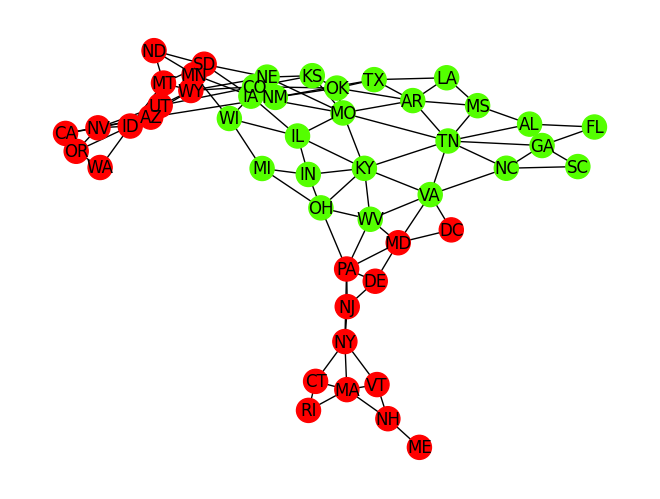

In [56]:
#A alternative clustering algorithm implementation

partition_array3 = nx.algorithms.community.kernighan_lin_bisection(contiguous)

community1 = partition_array3[0]
community2 = partition_array3[1]

colour_array = np.zeros(node_count)

#Change the zeros for the nodes in community 2 to a 1 so that nodes in community 1 and nodes in community 2 are different colours
for i in community2:
    index = int(i) - 1 #nodes start from 1 but indices for arrays start at 0
    colour_array[index] = 1

nx.draw(contiguous, contiguous_positions,node_color=colour_array, cmap=plt.cm.prism,
                            with_labels=True,labels=state_dict)

In [57]:
#Brief foray into similarity measures

#There are two partitions for each partitioning

spectral_partition_array_1 = partition_array2.astype(int)

spectral_partition_array_2 = np.zeros(spectral_partition_array_1.size)

#Generates the opposite partition
for i in range(spectral_partition_array_2.size):
    if spectral_partition_array_1[i] == 1:
        spectral_partition_array_2[i] = 0
    else:
        spectral_partition_array_2[i] = 1

spectral_partition_array_2 = spectral_partition_array_2.astype(int)

lin_partition_array_1 = (colour_array.astype(int))

lin_partition_array_2 = np.zeros(spectral_partition_array_1.size)

lin_partition_array_2 = lin_partition_array_2.astype(int)

for i in range(lin_partition_array_2.size):
    if lin_partition_array_1[i] == 1:
        lin_partition_array_2[i] = 0
    else:
        lin_partition_array_2[i] = 1
#Calculates the values for all proposed similarities
proposed_similarity_1 = sklearn.metrics.jaccard_score(spectral_partition_array_1, lin_partition_array_1)
proposed_similarity_2 = sklearn.metrics.jaccard_score(spectral_partition_array_2, lin_partition_array_1)
proposed_similarity_3 = sklearn.metrics.jaccard_score(spectral_partition_array_1, lin_partition_array_2)
proposed_similarity_4 = sklearn.metrics.jaccard_score(spectral_partition_array_2, lin_partition_array_2)

#Finds the highest similarities
list_proposed_similarities = [proposed_similarity_1 ,proposed_similarity_2 , proposed_similarity_3 ,proposed_similarity_4]
maximum_value = -0.1
position = -1

print(list_proposed_similarities)

for i in range(len(list_proposed_similarities)):
    if maximum_value <= list_proposed_similarities[i]:
        position = i
        maximum_value = list_proposed_similarities[i]
#By position prints the appropriate matching of partitions
if position == 0 or position == 3:
    print("Spectral partition one matches with lin partition one, with a similarity score of " + str(proposed_similarity_1) +
          " and spectral partition two matches with lin partition two, with a similarity score of " + str(proposed_similarity_4))
elif position == 1 or position == 2:
    print("Spectral partition one matches with lin partition two, with a similarity score of " + str(proposed_similarity_2) +
          " and spectral partition two matches with lin partition one, with a similarity score of " + str(proposed_similarity_3))

[0.08108108108108109, 0.5945945945945946, 0.4444444444444444, 0.2608695652173913]
Spectral partition one matches with lin partition two, with a similarity score of 0.5945945945945946 and spectral partition two matches with lin partition one, with a similarity score of 0.4444444444444444


[1 1 1 1 3 3 3 1 2 2 3 1 1 1 2 2 3 1 2 1 2 1 2 0 0 0 4 0 2 4 2 0 2 2]
This is the ZKC graph split into 5 clusters


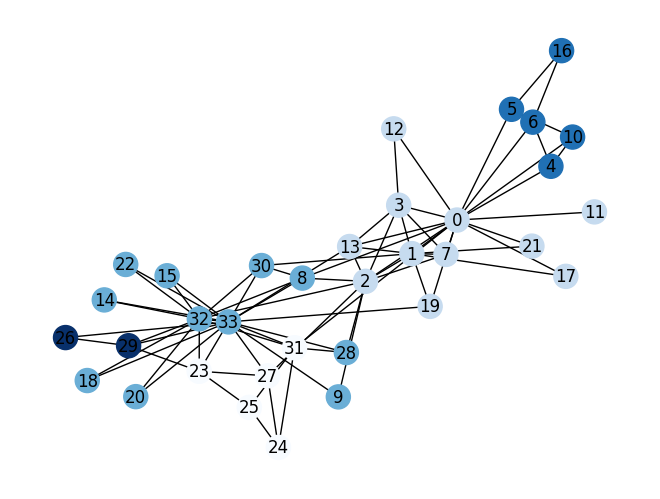

In [58]:
ZKC_graph = nx.karate_club_graph()

A = nx.to_numpy_array(ZKC_graph)

result = sklearn.cluster.spectral_clustering(A, n_clusters = 5)

print(result)

nx.draw(ZKC_graph, node_color=result, cmap=plt.cm.Blues,
                            with_labels=True)

print("This is the ZKC graph split into 5 clusters")

[0 0 0 0 2 2 2 0 1 1 2 0 0 0 1 1 2 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
This is the ZKC graph split into 3 clusters


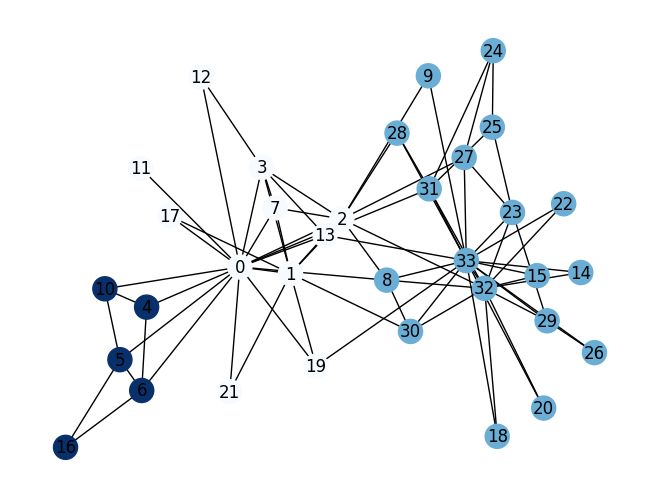

In [59]:
ZKC_graph = nx.karate_club_graph()

A = nx.to_numpy_array(ZKC_graph)

result = sklearn.cluster.spectral_clustering(A, n_clusters = 3)

print(result)

nx.draw(ZKC_graph, node_color=result, cmap=plt.cm.Blues,
                            with_labels=True)

print("This is the ZKC graph split into 3 clusters")

[4 4 4 4 4 4 4 0 0 4 1 1 0 1 1 1 0 0 0 0 2 2 2 2 3 3 3 3 3 3 4 4 0 0 0 0 0
 1 0 1 3 3 3 3 3 2 2 2 0]
This is the contiguous usa network split into 5 clusters


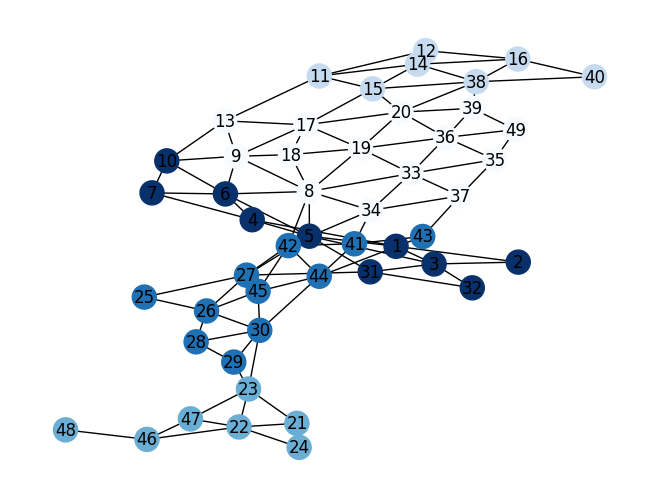

In [60]:
A = nx.to_numpy_array(contiguous)

result = sklearn.cluster.spectral_clustering(A, n_clusters = 5)

print(result)

nx.draw(contiguous, node_color=result, cmap=plt.cm.Blues,
                            with_labels=True)

print("This is the contiguous usa network split into 5 clusters")

[0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 0 0 0 0 2 0 0 0 1 0 1 1 0
 1 1 1 0 0 0 0 0 2 2 2 1]
This is the contiguous usa network split into 3 clusters


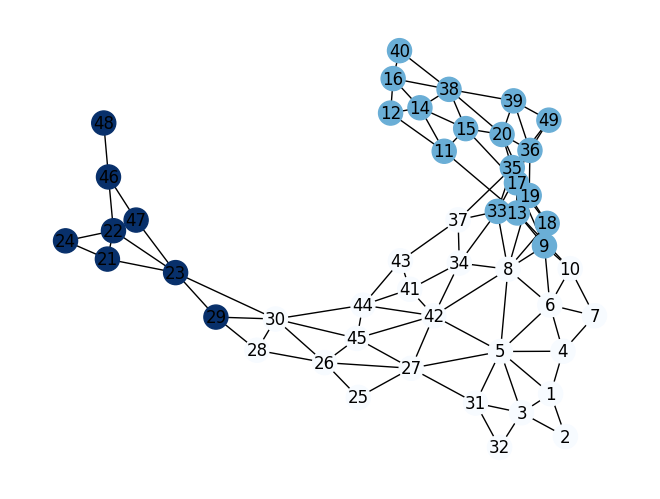

In [61]:
A = nx.to_numpy_array(contiguous)

result = sklearn.cluster.spectral_clustering(A, n_clusters = 3)

print(result)

nx.draw(contiguous, node_color=result, cmap=plt.cm.Blues,
                            with_labels=True)

print("This is the contiguous usa network split into 3 clusters")

$\textbf{Abstract:} $

Most of this work analyses the famous Karate Club Network. This analysed the social relationships to predict the resulting split.

$\textbf{Discussion of the spectral bipartition:} $

One way to find clusters is to minimize the cut size of a partition. The eigenvector corresponding to the second smallest eigenvalue of the Laplacian is called the *Fiedler vector*.
It can be shown that an approximate solution to cut size minimization for the case of two clusters can be obtained through the Fiedler vector. Using the signs of the Fiedler eigenvector, one can write a heuristic algorithm that splits the nodes in the Karate Club into two clusters. One can then encode the clustering using a partition array.

The following explanation can be found in the paper: Finding community structure in networks using the eigenvectors of matrices, by M. E. J. Newman

From the definition of $s_i$, we can construct the following function:
 \begin{equation*}
\frac{1}{2}(1 - s_i s_j) =
     \begin{cases} 1 & \text{if } i \text{ and } j \text{ are in different groups}, \\ 0 & \text{if } i \text{ and } j \text{ are in the same group}.       \end{cases} \end{equation*}
as if they were in the same group then $s_i = s_j$ and the function would output 0. If they were different $s_i = -s_j$ and the function would output 1. We can now rewrite the definition of the cut size as:


\begin{equation*}
 R = \frac{1}{4} \sum_{ij} (1 - s_i s_j)A_{ij} .
 \end{equation*}

We can now sum over all i,j. This is because each term of the sum returns the same value if i,j are in different groups but 0 if they are not, not contributing to the final sum.

The degree of a node of a network is defined below:

\begin{equation*}
  k_i = \sum_j A_{ij} ,
 \end{equation*}

 This allows us to rewrite the adjancency matrix as:

 \begin{equation*}
    \sum_{ij} A_{ij} = \sum_i k_i = \sum_i s_i^2 k_i = \sum_i s_i k_i \sum_{j:i=j} s_j = \sum_i s_i k_i \sum_j s_j \delta_{ij} = \sum_i \sum_j s_i s_j k_i \delta_{ij}
\end{equation*}

By expanding latest cut size formula and substituting using the last result we obtain:

 \begin{equation*}
     R = \frac{1}{4} \sum_{ij} s_i s_j (k_i \delta_{ij} - A_{ij}) .
 \end{equation*}

 As $L_{ij} = k_i \delta_{ij} - A_{ij}$ then:

 \begin{equation*}
      R = \frac{1}{4}s^TLs
 \end{equation*}

$ \textbf{Kerningham-Lin Algorithm} $

The Kerningham-Lin Algorithm finds a locally optimal partition and is a technique that can be compared to spectral biparititioning.

Firstly an initial partition is decided arbitrarily, splitting the set of nodes into two disjoint subsets equal in cardinality, labelled A and B, then the following algorithm is applied iteratively. For each pair of nodes such that one node is in A and the other is in B, it is calculated how much the number of edges crossing the partition would be changed by if the pair were swapped so that the node in A goes to B and the node in B goes to A. The algorithm then selects the subset of pairs such that swapping each pair reduces the number of edges crossing the partition maximally, and then swaps them. This algorithm repeats until it is not possible to reduce the number of edges cut by the partition any further by swapping nodes between A and B.

The psuedocode for the algorithm is as follows, sourced from Wikipedia Kernighan–Lin algorithm

function Kernighan-Lin(G(V, E)) is determine a balanced initial partition of the nodes into sets A and B do compute D values for all a in A and b in B let gv, av, and bv be empty lists for n := 1 to |V| / 2 do find a from A and b from B, such that g = D[a] + D[b] − 2×c(a, b) is maximal remove a and b from further consideration in this pass add g to gv, a to av, and b to bv update D values for the elements of A = A \ a and B = B \ b end for find k which maximizes g_max, the sum of gv[1], ..., gv[k] if g_max > 0 then Exchange av[1], av[2], ..., av[k] with bv[1], bv[2], ..., bv[k] until (g_max ≤ 0) return G(V, E)

Often it is useful to compare partitions. One metric to this is using the Jacard Index. To calculate the Jacard index of two sets you calculate the ratio of the cardinality of the intersection over the cardinality of the union of the two sets. To compare, using the Spectral and Kerningham-Lin methods, we must find the two partitions (out of four) that our most similar but generated using different methods, by calculating all Jaccard indexes and then match the other two sets and calculate that Jaccard Index. This is shown below.

$ \textbf{Similarities:} $

Both algorithms are heuristic methods, meaning they are approximate solutions not guaranteed to provide the best result. Heuristic methods are needed since partitioning networks is an NP hard problem so there is no algorithm for perfectly partitioning a network that runs in polynomial time. Therefore partitioning a large network is not computationally feasible without heuristic methods, since the computing power necessary increases exponentially as more nodes are added.

Both algorithms are similarly computationally expensive, though Kerningham-Lin is slightly moreso. The Kerninghan Lin algorithm has a running time of O(n^2 logn) for each pass (typically multiple passes are required), while calculating the feidler eigenvector for a spectral bipartition has a running time of O(n^2).

$\textbf{Differences:}$

The Kerninghan Lin method of bipartitioning differs from Spectral Bipartitioning mainly in that it is local rather than global. While global methods rely on a single computation based on the properties of the network, in the case of SB, finding the eigenvectors of the Laplacian, local methods choose an arbitrary initial partition and then use an algorithm to improve it iteratively. The advantage of a global method is that it can capture the entire structure of the network, whereas local methods can finely tune a partition iteratively.

The Kerninghan-Lin algorithm is dependent upon the initial partition provided, and some initial partitions may result in better solutions than others. This dependence could be mitigated by trying Kerninghan Lin on many different choices of initial partitions and then selecting the best result. This is not a problem spectral bipartitioning has, since it is not reliant on an initial partition.

The Kerninghan Lin algorithm can only split a network into two equal subsets which may result in the algorithm choosing an inferior partition simply because the superior partition would necessitate an uneven split. Spectral Bipartitioning on the other hand, allows for an uneven partition though it retains a preference for an even partition.

$\textbf{Extending Spectral Bipartitioning}$

Spectral bipartitioning can be extended to split a network into more than two communities as follows. Similarly, the laplacian of the graph is calculated as are its eigenvectors. If k communities are desired, the eigenvectors with the k smallest eigenvalues are selected and grouped into an n x k matrix. This can be interpreted as a list of n vectors in a k dimensional vector space and hence can be clustered using k-means clustering, which is a method of partitioning a set of vectors. See [k-means clustering](k-means clustering - Wikipedia.). It is not possible however to extend the Kerninghan Ling algorithm to identify more than two communities in a similar way.